In [1]:
!pip install -U "monai[all]" pyyaml munch

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━

In [2]:
!nvidia-smi

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Feb 26 07:25:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--------------

In [3]:
import os
from glob import glob

import torch
from monai.transforms import (
    Compose,
    LoadImaged,
    ToTensord,
    #AddChanneld,
    Activations,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    NormalizeIntensityd,
    ScaleIntensityd,
    RandBiasFieldd,
    RandGaussianSmoothd,
    RandGibbsNoised,
    RandAffined,
    RandRotate90d,
    RandRotated,
    Rand3DElasticd as RandElasticd,
    RandZoomd,
    RandCropByPosNegLabeld,
    RandGaussianNoised,
    RandShiftIntensityd,
    RandGaussianSharpend,
    RandAdjustContrastd,
    RandCropByPosNegLabeld,
    RandGaussianNoised,
    RandShiftIntensityd,
    RandGaussianSharpend,
    RandAdjustContrastd,
    CropForegroundd,
    MapTransform,
    SqueezeDimd,
    EnsureType,
    EnsureTyped,
    AsDiscrete,
    AsDiscreted,
    #Resized,

)

from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.handlers.utils import from_engine
from monai.utils import first
from monai.config import print_config
from monai.apps import download_and_extract
from monai.networks.nets import UNet
from monai.metrics import DiceMetric,HausdorffDistanceMetric,SurfaceDistanceMetric
from monai.inferers import sliding_window_inference
from monai.utils.enums import CommonKeys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import monai

In [4]:
print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.6.4
TorchVision version: 0.13.0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.2
pandas version: 1.3.5
einops version: 0.6.0
transformers version: 4.20.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
print(torch.__version__)

1.12.0


In [6]:
base_dir='/kaggle/input/prostate158-train2/prostate158_train'
train_csv ='/kaggle/input/prostate158-train2/prostate158_train/train.csv'
valid_csv = '/kaggle/input/prostate158-train2/prostate158_train/valid.csv'

train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)

train_df.fillna(value='', inplace=True)
valid_df.fillna(value='', inplace=True)

In [7]:
train_df.head(5)

,ID,t2,adc,dwi,t2_anatomy_reader1,t2_tumor_reader1,adc_tumor_reader1,t2_anatomy_reader2,adc_tumor_reader2
0,24,train/024/t2.nii/t2.nii,train/024/adc.nii/adc.nii,train/024/dwi.nii/dwi.nii,train/024/t2_anatomy_reader1.nii/t2_anatomy_re...,,train/024/empty.nii.gz,,
1,25,train/025/t2.nii/t2.nii,train/025/adc.nii/adc.nii,train/025/dwi.nii/dwi.nii,train/025/t2_anatomy_reader1.nii/t2_anatomy_re...,train/025/t2_tumor_reader1.nii/t2_tumor_reader...,train/025/adc_tumor_reader1.nii/adc_tumor_read...,,train/025/adc_tumor_reader2.nii/adc_tumor_read...
2,26,train/026/t2.nii/t2.nii,train/026/adc.nii/adc.nii,train/026/dwi.nii/dwi.nii,train/026/t2_anatomy_reader1.nii/t2_anatomy_re...,,train/026/empty.nii.gz,,
3,27,train/027/t2.nii/t2.nii,train/027/adc.nii/adc.nii,train/027/dwi.nii/dwi.nii,train/027/t2_anatomy_reader1.nii/t2_anatomy_re...,train/027/t2_tumor_reader1.nii/t2_tumor_reader...,train/027/adc_tumor_reader1.nii/adc_tumor_read...,,train/027/adc_tumor_reader2.nii/adc_tumor_read...
4,28,train/028/t2.nii/t2.nii,train/028/adc.nii/adc.nii,train/028/dwi.nii/dwi.nii,train/028/t2_anatomy_reader1.nii/t2_anatomy_re...,,train/028/empty.nii.gz,,


In [8]:
valid_df.head(5)

,ID,t2,adc,dwi,t2_anatomy_reader1,t2_tumor_reader1,adc_tumor_reader1,t2_anatomy_reader2,adc_tumor_reader2
0,20,train/020/t2.nii/t2.nii,train/020/adc.nii/adc.nii,train/020/dwi.nii/dwi.nii,train/020/t2_anatomy_reader1.nii/t2_anatomy_re...,train/020/t2_tumor_reader1.nii/t2_tumor_reader...,train/020/adc_tumor_reader1.nii/adc_tumor_read...,,train/020/adc_tumor_reader2.nii/adc_tumor_read...
1,21,train/021/t2.nii/t2.nii,train/021/adc.nii/adc.nii,train/021/dwi.nii/dwi.nii,train/021/t2_anatomy_reader1.nii/t2_anatomy_re...,train/021/t2_tumor_reader1.nii/t2_tumor_reader...,train/021/adc_tumor_reader1.nii/adc_tumor_read...,,train/021/adc_tumor_reader2.nii/adc_tumor_read...
2,22,train/022/t2.nii/t2.nii,train/022/adc.nii/adc.nii,train/022/dwi.nii/dwi.nii,train/022/t2_anatomy_reader1.nii/t2_anatomy_re...,,train/022/empty.nii.gz,,
3,23,train/023/t2.nii/t2.nii,train/023/adc.nii/adc.nii,train/023/dwi.nii/dwi.nii,train/023/t2_anatomy_reader1.nii/t2_anatomy_re...,,train/023/empty.nii.gz,,
4,38,train/038/t2.nii/t2.nii,train/038/adc.nii/adc.nii,train/038/dwi.nii/dwi.nii,train/038/t2_anatomy_reader1.nii/t2_anatomy_re...,train/038/t2_tumor_reader1.nii/t2_tumor_reader...,train/038/adc_tumor_reader1.nii/adc_tumor_read...,,


In [9]:
t2_mri=train_df[['t2']].squeeze().tolist()
t2_valid=valid_df[['t2']].squeeze().tolist()

mask_files=train_df[['t2_anatomy_reader1']].squeeze().tolist()
vali_masks=valid_df[['t2_anatomy_reader1']].squeeze().tolist()

In [10]:
train_images=[]
valid_images=[]

train_masks=[]
valid_masks=[]

for i in range(len(t2_mri)):
  train_images.append(os.path.join(base_dir,t2_mri[i]))
  train_masks.append(os.path.join(base_dir,mask_files[i]))
  #current_axis_codes = nib.aff2axcodes(nib.load(os.path.join(base_dir,t2_mri[i])).affine)
  #print(current_axis_codes)

for i in range(len(t2_valid)):
  valid_images.append(os.path.join(base_dir,t2_valid[i]))
  valid_masks.append(os.path.join(base_dir,vali_masks[i]))

In [11]:
train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_masks)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(valid_images, valid_masks)]

In [12]:
train_files[0]
prob=0.175
mode='bilinear'

In [13]:
class ConvertToMultiChannelBasedOnPancreaClassesd(MapTransform):
    """
    Convert labels to multi channels:
    label 0 is Background
    label 1 is CZ(Central Zone)
    label 2 is PZ(Peripheral Zone)
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] == 0)
            result.append(d[key] == 1)
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [14]:
orig_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        
        ToTensord(keys=['image', 'label'])
    ]
)

train_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(0.5, 0.5, 0.5)),
        Orientationd(keys=['image', 'label'],axcodes='RAS'),
        ScaleIntensityd(keys='image',minv=0,maxv=1),
        NormalizeIntensityd(keys='image'),
        RandBiasFieldd(keys='image', degree=10, coeff_range=[0.0,0.01], prob=prob),
        RandGaussianSmoothd(keys='image',sigma_x=[0.25, 1.5], sigma_y=[0.25, 1.5], sigma_z=[0.25, 1.5],prob=prob),
        RandGibbsNoised(keys='image', alpha=[0.5,1], prob=prob),
        RandAffined(
                keys=['image', 'label'],rotate_range=5, shear_range=0.5, translate_range=25,mode=['bilinear' , 'nearest'],prob=prob),
        RandRotate90d(keys=['image', 'label'],spatial_axes=[0,1],prob=prob),
        RandRotated(keys=['image', 'label'],range_x=0.1, range_y=0.1, range_z=0.1,mode=['bilinear','nearest'],prob=prob),
        RandElasticd(keys=['image', 'label'],sigma_range= [0.5,1.5],magnitude_range= [0.5,1.5],rotate_range=5,shear_range=0.5,translate_range=25,
                     mode=['bilinear' , 'nearest'],prob=prob),
        #RandZoomd(keys=['image', 'label'],min_zoom=0.9,max_zoom=1.1,mode=['bilinear','nearest'],prob=prob),
        RandCropByPosNegLabeld(keys=['image', 'label'],label_key='label',spatial_size=[96, 96, 96],pos=2,neg=1,num_samples=8,
                image_key='image',image_threshold=0,),
        SqueezeDimd(keys=["label"],dim=0),
        ConvertToMultiChannelBasedOnPancreaClassesd(keys="label"),
        RandGaussianNoised(keys='image',mean=0.1,std=0.25,prob=prob),
        RandShiftIntensityd(keys='image',offsets=0.2,prob=prob),
        RandGaussianSharpend(
                keys='image',
                sigma1_x=[0.5, 1.0],sigma1_y=[0.5, 1.0],sigma1_z=[0.5, 1.0],
                sigma2_x=[0.5, 1.0],sigma2_y=[0.5, 1.0],sigma2_z=[0.5, 1.0],
                alpha=[10.0, 30.0],prob=prob),
        RandAdjustContrastd(keys='image',gamma=2.0,prob=prob),
        #CropForegroundd(keys=['image', 'label'], source_key='image'),
        EnsureTyped(keys=['image', 'label']),
        #Resized(keys=['image', 'label'], spatial_size=[128,128,128]),
        ToTensord(keys=['image', 'label'])
    ]
)


val_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(0.5, 0.5, 0.5)),
        Orientationd(keys=['image', 'label'],axcodes='RAS'),
        SqueezeDimd(keys=["label"],dim=0),
        ConvertToMultiChannelBasedOnPancreaClassesd(keys="label"),
        ScaleIntensityd(keys='image',minv=0,maxv=1),
        NormalizeIntensityd(keys='image'),
        #CropForegroundd(keys=['image', 'label'], source_key='image'),
        EnsureTyped(keys=['image', 'label']),
        ToTensord(keys=['image', 'label'])
    ]
)

In [15]:
orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

In [16]:
#x=train_loader.dataset

In [17]:
#len(x[0])

In [18]:
test_patient = first(train_loader)
orig_patient = first(orig_loader)

In [19]:
print(torch.min(test_patient['image']))
print(torch.max(test_patient['image']))

tensor(-10.1920)
tensor(19.3133)


In [20]:
#a=np.array(orig_ds[0]['image'])

In [21]:
#np.max(a)

In [22]:
#im=np.array(orig_patient['image'][0, 0, : ,: ,20])
#print(im.shape)

In [23]:
#np.max(im)

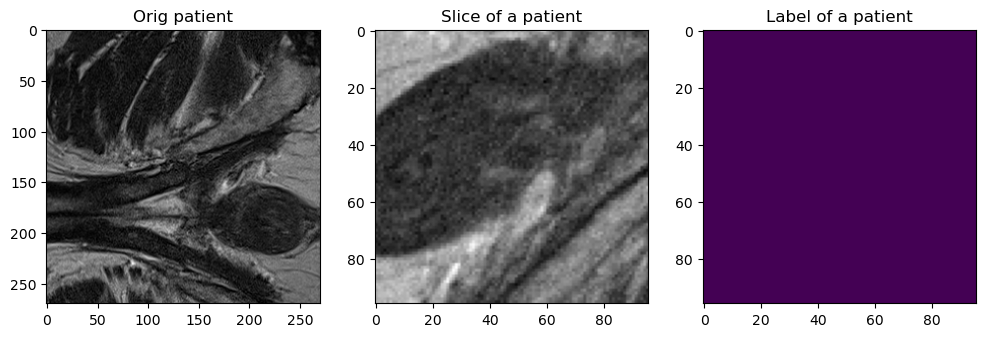

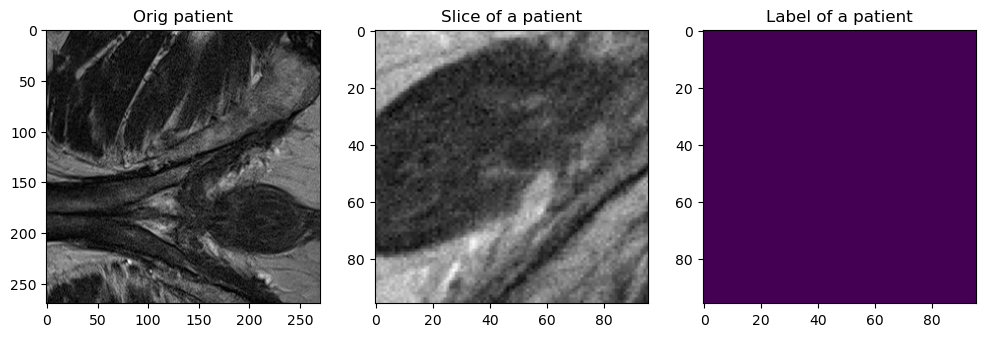

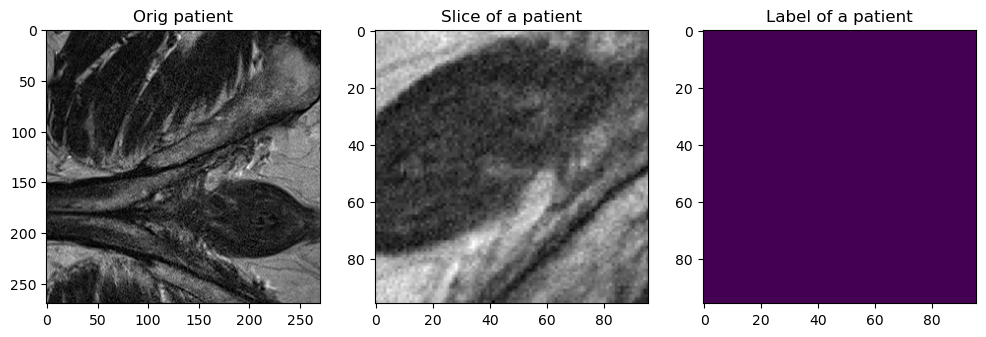

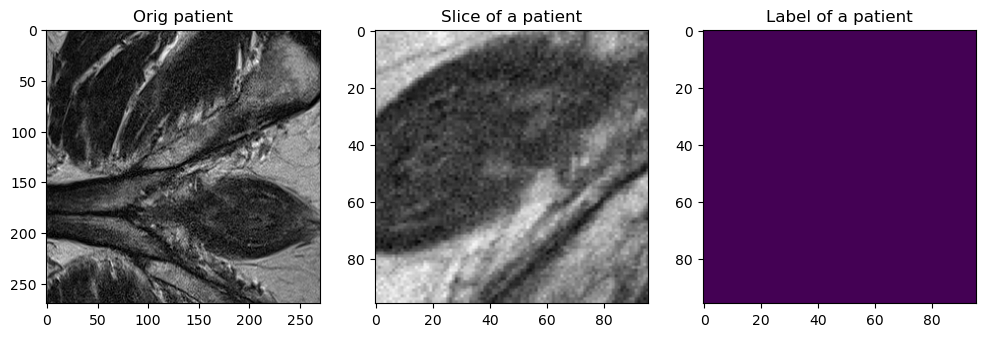

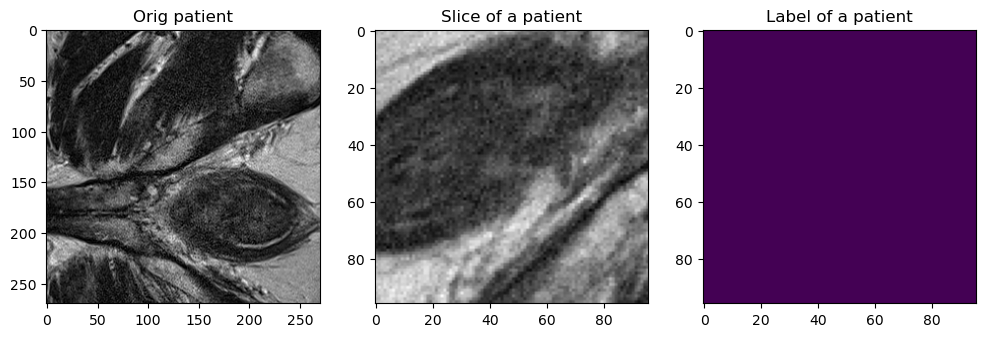

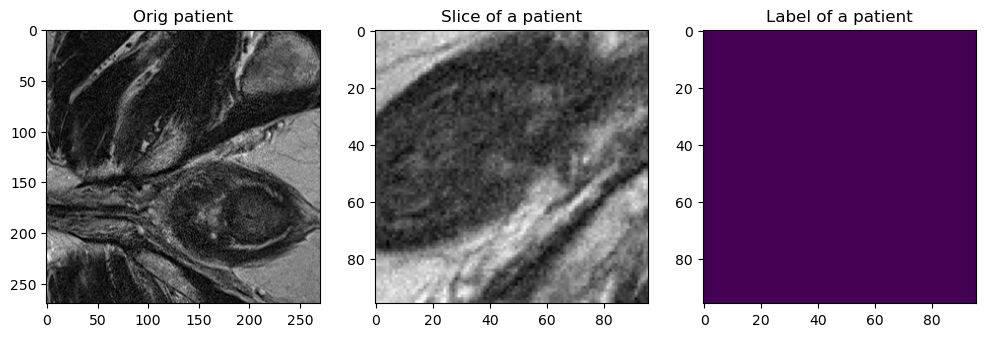

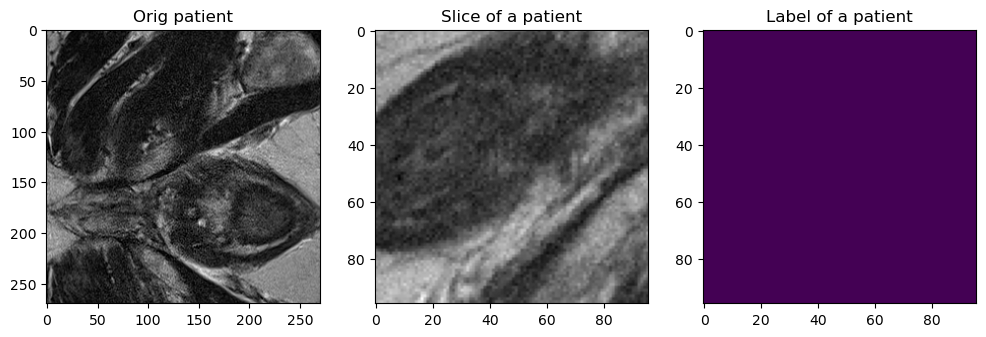

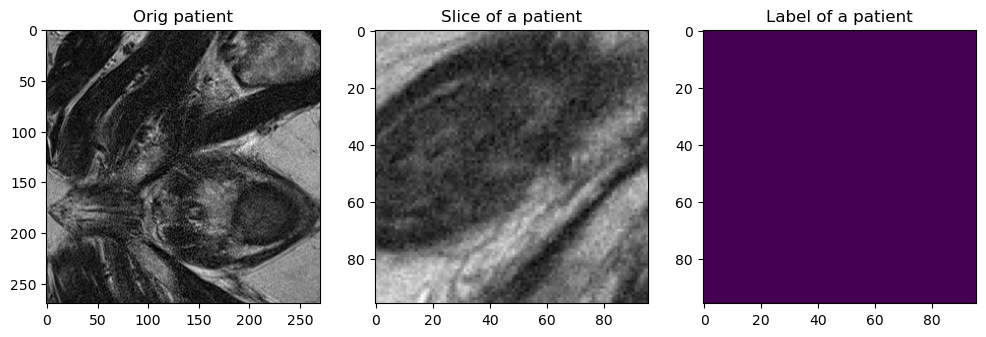

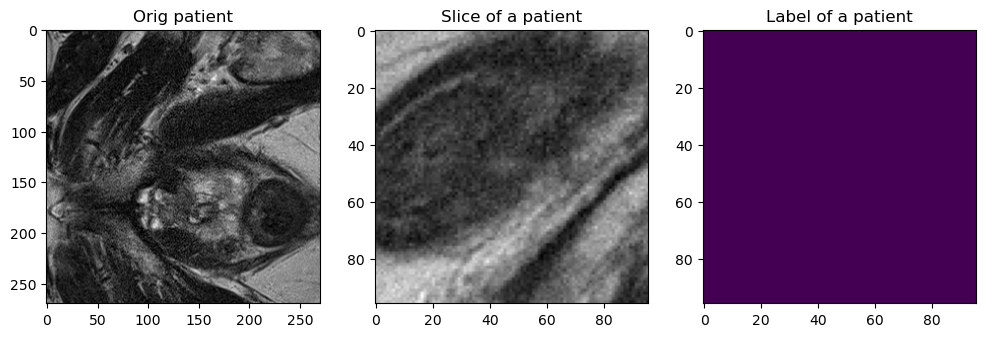

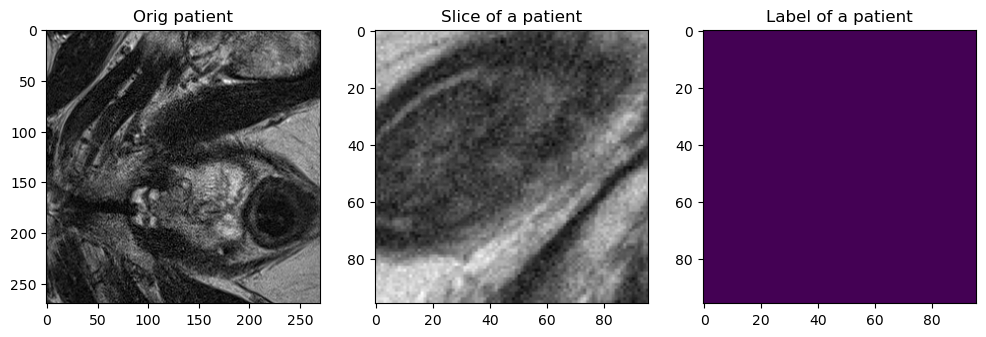

In [24]:
for i in range(10):
  plt.figure('test', (12, 6))
  plt.subplot(1, 3, 1)
  plt.title('Orig patient')
  plt.imshow(orig_patient['image'][0, 0, : ,: ,i], cmap= "gray")

  plt.subplot(1, 3, 2)
  plt.title('Slice of a patient')
  plt.imshow(test_patient['image'][0, 0, : ,: ,i], cmap= "gray")

  plt.subplot(1,3,3)
  plt.title('Label of a patient')
  plt.imshow(test_patient['label'][0, 0, : ,: ,i])
  plt.show()

In [25]:
from monai.losses import DiceCELoss,DiceLoss
from monai.optimizers import Novograd

In [26]:
torch.cuda.is_available()

True

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def get_model():
    return UNet(
        spatial_dims= 3,
        in_channels=1,
        out_channels=3,
        channels=[16, 32, 64, 128, 256, 512],
        strides=[2, 2, 2, 2, 2],
        num_res_units=4,
        act='PRELU',
        norm='BATCH',
        dropout=0.15,
            ).to(device)

In [28]:
model=get_model()
#loss_function = DiceCELoss(include_background=False,softmax=True,to_onehot_y=True)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = Novograd(model.parameters(), lr=0.001,weight_decay=0.01 ,amsgrad=True)


dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

hd95_metric = HausdorffDistanceMetric(include_background=True, percentile=95, reduction="mean")
hd95_metric_batch = HausdorffDistanceMetric(include_background=True, percentile=95, reduction="mean_batch")

sd_metric =  SurfaceDistanceMetric(include_background=True, symmetric=True, reduction="mean")
sd_metric_batch =  SurfaceDistanceMetric(include_background=True, symmetric=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


In [29]:
checkpoint = torch.load("/kaggle/input/checkpoint2/checkpoint2.pth")

In [30]:
print(checkpoint.keys())
#print(checkpoint['state_dict'])

dict_keys(['epoch', 'model', 'state_dict', 'optimizer'])


In [31]:
model=checkpoint['model']
ep=checkpoint['epoch']
#optimizer=checkpoint['optimizer']
optimizer.load_state_dict(checkpoint['optimizer'])
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [32]:
#print(optimizer)

In [33]:
max_epochs = ep+36
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []

cor_hd=0
cor_asd=0


metric_values = []
metric_values_bg = []
metric_values_CZ = []
metric_values_PZ = []

hd_metric_values = []
hd_metric_values_bg = []
hd_metric_values_CZ = []
hd_metric_values_PZ = []

ssd_metric_values = []
ssd_metric_values_bg = []
ssd_metric_values_CZ = []
ssd_metric_values_PZ = []


n_classes=3
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=n_classes)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=n_classes)])

for epoch in range(ep,max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (96, 96, 96)
                sw_batch_size = 4
                overlap=0.5
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                #val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                #val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
                
                hd95_metric(y_pred=val_outputs, y=val_labels)
                hd95_metric_batch(y_pred=val_outputs, y=val_labels)
                
                sd_metric(y_pred=val_outputs, y=val_labels)
                sd_metric_batch(y_pred=val_outputs, y=val_labels)
                

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            
            metric_batch = dice_metric_batch.aggregate()
            
            
            metric_bg = metric_batch[0].item()
            metric_values_bg.append(metric_bg)
            metric_CZ = metric_batch[1].item()
            metric_values_CZ.append(metric_CZ)
            metric_PZ = metric_batch[2].item()
            metric_values_PZ.append(metric_PZ)
            # reset the status for next validation round
            dice_metric.reset()
            dice_metric_batch.reset()
            
            hd_metric = hd95_metric.aggregate().item()
            hd_metric_values.append(hd_metric)
            hd_metric_batch = hd95_metric_batch.aggregate()
            hd_metric_bg = hd_metric_batch[0].item()
            hd_metric_values_bg.append(hd_metric_bg)
            hd_metric_CZ = hd_metric_batch[1].item()
            hd_metric_values_CZ.append(hd_metric_CZ)
            hd_metric_PZ = hd_metric_batch[2].item()
            hd_metric_values_PZ.append(hd_metric_PZ)
            hd95_metric.reset()
            hd95_metric_batch.reset()
            
            
            ssd_metric = sd_metric.aggregate().item()
            ssd_metric_values.append(ssd_metric)
            ssd_metric_batch = sd_metric_batch.aggregate()
            ssd_metric_bg = ssd_metric_batch[0].item()
            ssd_metric_values_bg.append(ssd_metric_bg)
            ssd_metric_CZ = ssd_metric_batch[1].item()
            ssd_metric_values_CZ.append(ssd_metric_CZ)
            ssd_metric_PZ = ssd_metric_batch[2].item()
            ssd_metric_values_PZ.append(ssd_metric_PZ)
            sd_metric.reset()
            sd_metric_batch.reset()
            
            

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                cor_metricCZ=metric_CZ
                cor_metricPZ=metric_PZ
                cor_hd= hd_metric
                cor_hdCZ= hd_metric_CZ
                cor_hdPZ= hd_metric_PZ
                cor_asd=ssd_metric
                cor_asdCZ=ssd_metric_CZ
                cor_asdPZ=ssd_metric_PZ
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    "/kaggle/working/", "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\n BG: {metric_bg:.4f} CZ: {metric_CZ:.4f} PZ: {metric_PZ:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            
            print(
                f"current mean HD: {hd_metric:.4f}"
                f"\n BG: {hd_metric_bg:.4f} CZ: {hd_metric_CZ:.4f} PZ: {hd_metric_PZ:.4f}"
            )
            
            print(
                f"current mean ASD: {ssd_metric:.4f}"
                f"\n BG: {ssd_metric_bg:.4f} CZ: {ssd_metric_CZ:.4f} PZ: {ssd_metric_PZ:.4f}"
            )

----------
epoch 37/72
1/59, train_loss: 0.2905
2/59, train_loss: 0.2474
3/59, train_loss: 0.2494
4/59, train_loss: 0.3731
5/59, train_loss: 0.3613
6/59, train_loss: 0.3575
7/59, train_loss: 0.4339
8/59, train_loss: 0.2611
9/59, train_loss: 0.3359
10/59, train_loss: 0.3195
11/59, train_loss: 0.3724
12/59, train_loss: 0.2465
13/59, train_loss: 0.3160
14/59, train_loss: 0.3585
15/59, train_loss: 0.3154
16/59, train_loss: 0.4167
17/59, train_loss: 0.2324
18/59, train_loss: 0.2751
19/59, train_loss: 0.3035
20/59, train_loss: 0.2709
21/59, train_loss: 0.2968
22/59, train_loss: 0.3423
23/59, train_loss: 0.2078
24/59, train_loss: 0.2271
25/59, train_loss: 0.3529
26/59, train_loss: 0.1922
27/59, train_loss: 0.2481
28/59, train_loss: 0.3531
29/59, train_loss: 0.4047
30/59, train_loss: 0.2786
31/59, train_loss: 0.2093
32/59, train_loss: 0.3532
33/59, train_loss: 0.3562
34/59, train_loss: 0.2841
35/59, train_loss: 0.2593
36/59, train_loss: 0.4497
37/59, train_loss: 0.3507
38/59, train_loss: 0.313

Num foregrounds 558124, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.


53/59, train_loss: 0.5358
54/59, train_loss: 0.1686
55/59, train_loss: 0.2837
56/59, train_loss: 0.3107
57/59, train_loss: 0.3274
58/59, train_loss: 0.2527
59/59, train_loss: 0.3043
60/59, train_loss: 0.1167
epoch 37 average loss: 0.3129
----------
epoch 38/72
1/59, train_loss: 0.3539
2/59, train_loss: 0.3237
3/59, train_loss: 0.3276
4/59, train_loss: 0.3954
5/59, train_loss: 0.3126
6/59, train_loss: 0.3348
7/59, train_loss: 0.3425
8/59, train_loss: 0.3704
9/59, train_loss: 0.3884
10/59, train_loss: 0.4661
11/59, train_loss: 0.4466
12/59, train_loss: 0.2408
13/59, train_loss: 0.3420
14/59, train_loss: 0.2531
15/59, train_loss: 0.3017
16/59, train_loss: 0.2775
17/59, train_loss: 0.3189
18/59, train_loss: 0.1943
19/59, train_loss: 0.3609
20/59, train_loss: 0.3290
21/59, train_loss: 0.3785
22/59, train_loss: 0.3321
23/59, train_loss: 0.2140
24/59, train_loss: 0.2105
25/59, train_loss: 0.3728
26/59, train_loss: 0.2936
27/59, train_loss: 0.2262
28/59, train_loss: 0.3858
29/59, train_loss: 0

Num foregrounds 833909, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.


30/59, train_loss: 0.3919
31/59, train_loss: 0.1647
32/59, train_loss: 0.3361
33/59, train_loss: 0.2301
34/59, train_loss: 0.2461
35/59, train_loss: 0.2109
36/59, train_loss: 0.3446
37/59, train_loss: 0.3993
38/59, train_loss: 0.2541
39/59, train_loss: 0.3785
40/59, train_loss: 0.3150
41/59, train_loss: 0.1898
42/59, train_loss: 0.2413
43/59, train_loss: 0.3054
44/59, train_loss: 0.1848
45/59, train_loss: 0.3126
46/59, train_loss: 0.2321
47/59, train_loss: 0.3839
48/59, train_loss: 0.2705
49/59, train_loss: 0.3013
50/59, train_loss: 0.2582
51/59, train_loss: 0.3788
52/59, train_loss: 0.2651
53/59, train_loss: 0.1919
54/59, train_loss: 0.2597
55/59, train_loss: 0.3115
56/59, train_loss: 0.3445
57/59, train_loss: 0.3027
58/59, train_loss: 0.3235
59/59, train_loss: 0.2880
60/59, train_loss: 0.3732
epoch 49 average loss: 0.2943
----------
epoch 50/72
1/59, train_loss: 0.3295
2/59, train_loss: 0.2121
3/59, train_loss: 0.4208
4/59, train_loss: 0.3942
5/59, train_loss: 0.2539
6/59, train_loss

Num foregrounds 220828, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.


2/59, train_loss: 0.5602
3/59, train_loss: 0.2748
4/59, train_loss: 0.4810
5/59, train_loss: 0.2168
6/59, train_loss: 0.3498
7/59, train_loss: 0.2440
8/59, train_loss: 0.3448
9/59, train_loss: 0.3347
10/59, train_loss: 0.4026
11/59, train_loss: 0.4339
12/59, train_loss: 0.2256
13/59, train_loss: 0.3010
14/59, train_loss: 0.1907
15/59, train_loss: 0.3937
16/59, train_loss: 0.3445
17/59, train_loss: 0.3932
18/59, train_loss: 0.2168
19/59, train_loss: 0.2756
20/59, train_loss: 0.2476
21/59, train_loss: 0.2823
22/59, train_loss: 0.4069
23/59, train_loss: 0.1972
24/59, train_loss: 0.4611
25/59, train_loss: 0.2761
26/59, train_loss: 0.4134
27/59, train_loss: 0.2766
28/59, train_loss: 0.4607
29/59, train_loss: 0.2895
30/59, train_loss: 0.2552
31/59, train_loss: 0.2618
32/59, train_loss: 0.4005
33/59, train_loss: 0.3235
34/59, train_loss: 0.3972
35/59, train_loss: 0.3033
36/59, train_loss: 0.3307
37/59, train_loss: 0.2444
38/59, train_loss: 0.2948
39/59, train_loss: 0.3112
40/59, train_loss: 0

Num foregrounds 249798, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.


11/59, train_loss: 0.5082
12/59, train_loss: 0.2057
13/59, train_loss: 0.3320
14/59, train_loss: 0.3067
15/59, train_loss: 0.3732
16/59, train_loss: 0.3819
17/59, train_loss: 0.3604
18/59, train_loss: 0.2005
19/59, train_loss: 0.1906
20/59, train_loss: 0.2632
21/59, train_loss: 0.3612
22/59, train_loss: 0.3224
23/59, train_loss: 0.2113
24/59, train_loss: 0.2434
25/59, train_loss: 0.3188
26/59, train_loss: 0.2220
27/59, train_loss: 0.1997
28/59, train_loss: 0.3384
29/59, train_loss: 0.3113
30/59, train_loss: 0.1870
31/59, train_loss: 0.2362
32/59, train_loss: 0.2288
33/59, train_loss: 0.2814
34/59, train_loss: 0.3270
35/59, train_loss: 0.2552
36/59, train_loss: 0.3311
37/59, train_loss: 0.3215
38/59, train_loss: 0.3302
39/59, train_loss: 0.2469
40/59, train_loss: 0.1762
41/59, train_loss: 0.2141
42/59, train_loss: 0.3250
43/59, train_loss: 0.4403
44/59, train_loss: 0.2167
45/59, train_loss: 0.3936
46/59, train_loss: 0.2092
47/59, train_loss: 0.5424
48/59, train_loss: 0.2980
49/59, train

Num foregrounds 579204, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.


9/59, train_loss: 0.4313
10/59, train_loss: 0.4185
11/59, train_loss: 0.4369
12/59, train_loss: 0.3384
13/59, train_loss: 0.3533
14/59, train_loss: 0.3346
15/59, train_loss: 0.4167
16/59, train_loss: 0.3884
17/59, train_loss: 0.2547
18/59, train_loss: 0.2097
19/59, train_loss: 0.2442
20/59, train_loss: 0.2172
21/59, train_loss: 0.3457
22/59, train_loss: 0.4202
23/59, train_loss: 0.1836
24/59, train_loss: 0.2694
25/59, train_loss: 0.3646
26/59, train_loss: 0.2583
27/59, train_loss: 0.2252
28/59, train_loss: 0.4026
29/59, train_loss: 0.2863
30/59, train_loss: 0.3553
31/59, train_loss: 0.1984
32/59, train_loss: 0.2931
33/59, train_loss: 0.2575
34/59, train_loss: 0.3167
35/59, train_loss: 0.1572
36/59, train_loss: 0.3582
37/59, train_loss: 0.2498
38/59, train_loss: 0.3197
39/59, train_loss: 0.2741
40/59, train_loss: 0.1875
41/59, train_loss: 0.2435
42/59, train_loss: 0.2608
43/59, train_loss: 0.2726
44/59, train_loss: 0.1816
45/59, train_loss: 0.2681
46/59, train_loss: 0.2512
47/59, train_

Num foregrounds 503554, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.


27/59, train_loss: 0.4014
28/59, train_loss: 0.3296
29/59, train_loss: 0.3213
30/59, train_loss: 0.2495
31/59, train_loss: 0.2048
32/59, train_loss: 0.2644
33/59, train_loss: 0.2853
34/59, train_loss: 0.4032
35/59, train_loss: 0.3577
36/59, train_loss: 0.3811
37/59, train_loss: 0.3320
38/59, train_loss: 0.3597
39/59, train_loss: 0.3813
40/59, train_loss: 0.2314
41/59, train_loss: 0.2761
42/59, train_loss: 0.3845
43/59, train_loss: 0.4174
44/59, train_loss: 0.2217
45/59, train_loss: 0.2467
46/59, train_loss: 0.2336
47/59, train_loss: 0.4272
48/59, train_loss: 0.3338
49/59, train_loss: 0.4039
50/59, train_loss: 0.2879
51/59, train_loss: 0.2909
52/59, train_loss: 0.2954
53/59, train_loss: 0.3085
54/59, train_loss: 0.2346
55/59, train_loss: 0.3540
56/59, train_loss: 0.2816
57/59, train_loss: 0.3366
58/59, train_loss: 0.2809
59/59, train_loss: 0.3253
60/59, train_loss: 0.1908
epoch 69 average loss: 0.3091
----------
epoch 70/72
1/59, train_loss: 0.3685
2/59, train_loss: 0.3731
3/59, train_l

Num foregrounds 208986, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.


25/59, train_loss: 0.4732
26/59, train_loss: 0.2598
27/59, train_loss: 0.1862
28/59, train_loss: 0.4353
29/59, train_loss: 0.2684
30/59, train_loss: 0.2799
31/59, train_loss: 0.2738
32/59, train_loss: 0.3415
33/59, train_loss: 0.2910
34/59, train_loss: 0.4284
35/59, train_loss: 0.2670
36/59, train_loss: 0.4736
37/59, train_loss: 0.2419
38/59, train_loss: 0.2653
39/59, train_loss: 0.2488
40/59, train_loss: 0.2541
41/59, train_loss: 0.4023
42/59, train_loss: 0.4148
43/59, train_loss: 0.4386
44/59, train_loss: 0.2117
45/59, train_loss: 0.3629
46/59, train_loss: 0.3517
47/59, train_loss: 0.3563
48/59, train_loss: 0.3123
49/59, train_loss: 0.4135
50/59, train_loss: 0.2902
51/59, train_loss: 0.3167
52/59, train_loss: 0.4123
53/59, train_loss: 0.2202
54/59, train_loss: 0.1658
55/59, train_loss: 0.2897
56/59, train_loss: 0.2739
57/59, train_loss: 0.3047
58/59, train_loss: 0.2913
59/59, train_loss: 0.4217
60/59, train_loss: 0.4140
epoch 70 average loss: 0.3244
current epoch: 70 current mean dic

Num foregrounds 263630, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.


12/59, train_loss: 0.4411
13/59, train_loss: 0.3397
14/59, train_loss: 0.3231
15/59, train_loss: 0.4439
16/59, train_loss: 0.2197
17/59, train_loss: 0.3891
18/59, train_loss: 0.2738
19/59, train_loss: 0.2773
20/59, train_loss: 0.1684
21/59, train_loss: 0.2934
22/59, train_loss: 0.2069
23/59, train_loss: 0.2237
24/59, train_loss: 0.3871
25/59, train_loss: 0.2964
26/59, train_loss: 0.2890
27/59, train_loss: 0.2077
28/59, train_loss: 0.3495
29/59, train_loss: 0.3091
30/59, train_loss: 0.2786
31/59, train_loss: 0.2100
32/59, train_loss: 0.3977
33/59, train_loss: 0.3849
34/59, train_loss: 0.3946
35/59, train_loss: 0.2479
36/59, train_loss: 0.3435
37/59, train_loss: 0.2424
38/59, train_loss: 0.2713
39/59, train_loss: 0.2800
40/59, train_loss: 0.2067
41/59, train_loss: 0.2368
42/59, train_loss: 0.2830
43/59, train_loss: 0.3292
44/59, train_loss: 0.3097
45/59, train_loss: 0.4045
46/59, train_loss: 0.3193
47/59, train_loss: 0.4151
48/59, train_loss: 0.3111
49/59, train_loss: 0.2762
50/59, train

In [34]:
checkpoint2 = { 'epoch': epoch + 1,
                'model': get_model(),
                'state_dict': model.state_dict(),
                'optimizer_state' : optimizer.state_dict()}

torch.save(checkpoint2, 'checkpoint3.pth')

In [35]:
#len(val_outputs)
print(metric_values_CZ)

[0.756372332572937, 0.7511693239212036, 0.7391527891159058, 0.7349229454994202, 0.7374676465988159, 0.7339992523193359, 0.7319512367248535, 0.7504205703735352, 0.7712911367416382, 0.7383496761322021, 0.7591700553894043, 0.7297195792198181, 0.7245239019393921, 0.7618223428726196, 0.7568358182907104, 0.7396336793899536, 0.7473467588424683, 0.7383812069892883]


In [36]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"\nMetric_CZ: {cor_metricCZ} Metric_PZ: {cor_metricPZ} "
    f"\nHD: {cor_hd} ASD: {cor_asd} "
    f"\nHD_CZ: {cor_hdCZ} HD_PZ: {cor_hdPZ} "
    f"\nASD_CZ: {cor_asdCZ} ASD_PZ: {cor_asdPZ} "
    f"at epoch: {best_metric_epoch} ")

train completed, best_metric: 0.7775 
Metric_CZ: 0.7712911367416382 Metric_PZ: 0.572236180305481 
HD: 36.11887482930197 ASD: 5.907285563800303 
HD_CZ: 53.035905549223116 HD_PZ: 48.826711477802554 
ASD_CZ: 9.487884014195838 ASD_PZ: 7.530077245524478 at epoch: 54 


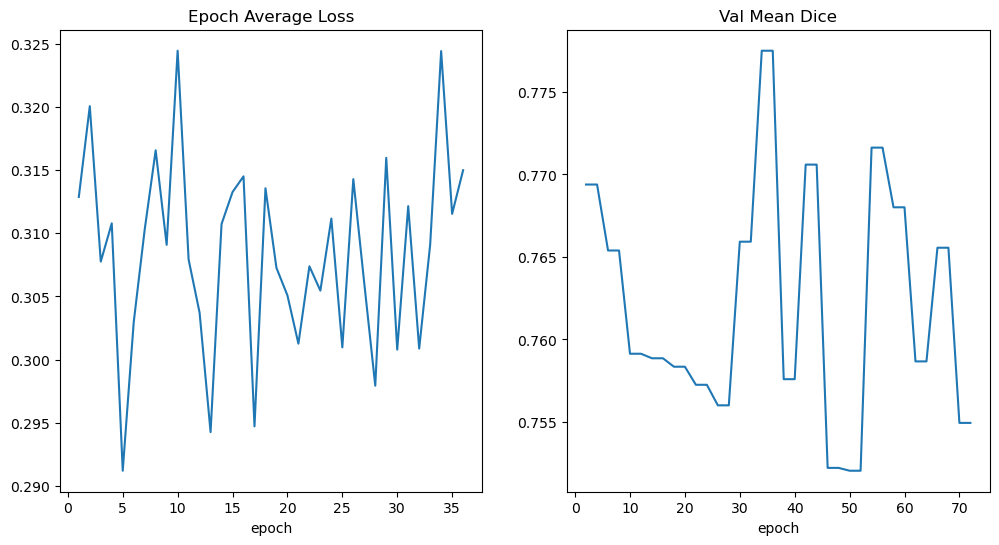

In [37]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

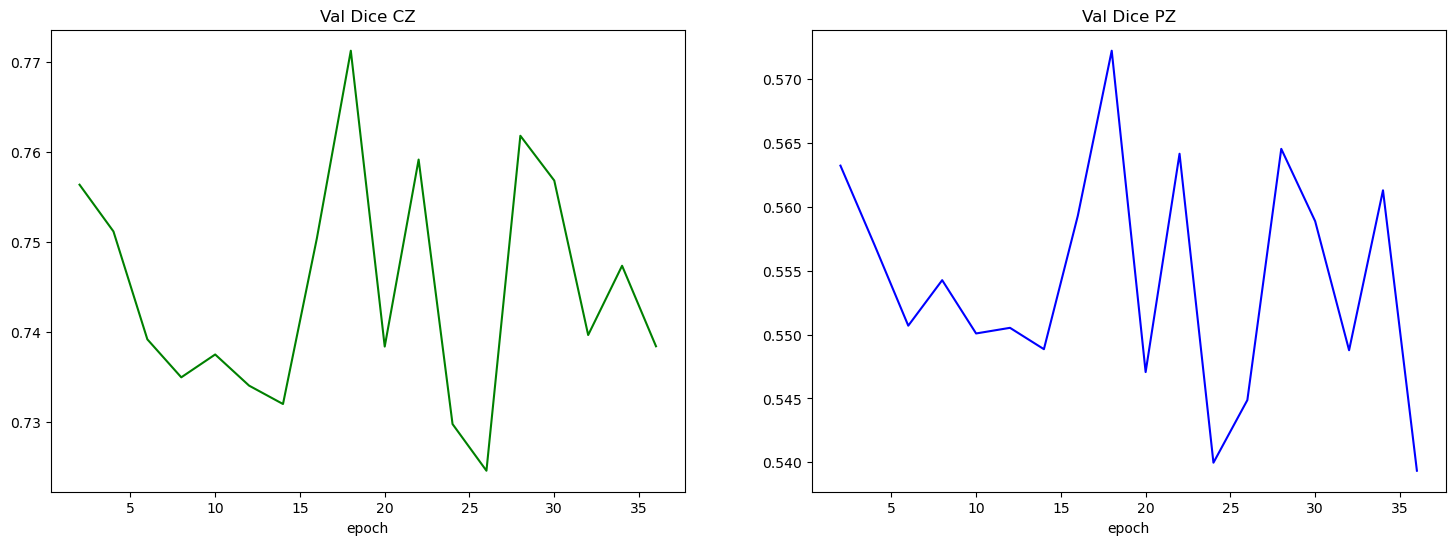

In [38]:
plt.figure("train", (18, 6))
#plt.subplot(1, 3, 1)
#plt.title("Val Mean Dice Background")
#x = [val_interval * (i + 1) for i in range(len(metric_values_bg))]
#y = metric_values_bg
#plt.xlabel("epoch")
#plt.plot(x, y, color="blue")
plt.subplot(1, 2, 1)
plt.title("Val Dice CZ")
x = [val_interval * (i + 1) for i in range(len(metric_values_CZ))]
y = metric_values_CZ
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.subplot(1, 2, 2)
plt.title("Val Dice PZ")
x = [val_interval * (i + 1) for i in range(len(metric_values_PZ))]
y = metric_values_PZ
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.show()